# read datas

In [1]:
import pymysql
import redis

#redis connection
r = redis.StrictRedis(host='172.17.0.2', port=6379, db=0)

#connect maria rdb
db = pymysql.connect(
        host='172.17.0.4',
        user='root',
        passwd='1234',
        db='rental',
        charset='utf8mb4'
    )
#設置cursor
cursor = db.cursor()
#cursor.execute('SELECT * FROM typeID;')

In [2]:
import numpy as np
import pandas as pd
cursor.execute("SELECT ID, lat, lng FROM rentInfo;")
df = pd.DataFrame(list(cursor.fetchall()))

In [3]:
df.columns = ['ID','lat', 'lng']

In [4]:
df.lat.apply(lambda x:float(x)).describe(percentiles=[.05, .25, .75, .95])

count    24799.000000
mean        24.915467
std          1.876888
min          0.000000
5%          24.976537
25%         25.022793
50%         25.049868
75%         25.079249
95%         25.175369
max         44.625102
Name: lat, dtype: float64

In [5]:
df.lng.apply(lambda x:float(x)).describe(percentiles=[.05, .25, .75, .95])

count    24799.000000
mean       120.806469
std          9.328587
min        -79.509823
5%         121.406501
25%        121.467302
50%        121.521828
75%        121.547050
95%        121.599642
max        121.925761
Name: lng, dtype: float64

In [6]:
df = df[df.lng>121]

# lat lng to TWD97

In [8]:
from math import tan, sin, cos, radians

class LatLonToTWD97(object):
    """This object provide method for converting lat/lon coordinate to TWD97
    coordinate

    the formula reference to
    http://www.uwgb.edu/dutchs/UsefulData/UTMFormulas.htm (there is lots of typo)
    http://www.offshorediver.com/software/utm/Converting UTM to Latitude and Longitude.doc

    Parameters reference to
    http://rskl.geog.ntu.edu.tw/team/gis/doc/ArcGIS/WGS84%20and%20TM2.htm
    http://blog.minstrel.idv.tw/2004/06/taiwan-datum-parameter.html
    """

    def __init__(self,
        a = 6378137.0,
        b = 6356752.314245,
        long0 = radians(121),
        k0 = 0.9999,
        dx = 250000,
    ):
        # Equatorial radius
        self.a = a
        # Polar radius
        self.b = b
        # central meridian of zone
        self.long0 = long0
        # scale along long0
        self.k0 = k0
        # delta x in meter
        self.dx = dx

    def convert(self, lat, lon):
        """Convert lat lon to twd97

        """
        a = self.a
        b = self.b
        long0 = self.long0
        k0 = self.k0
        dx = self.dx

        e = (1-b**2/a**2)**0.5
        e2 = e**2/(1-e**2)
        n = (a-b)/(a+b)
        nu = a/(1-(e**2)*(sin(lat)**2))**0.5
        p = lon-long0

        A = a*(1 - n + (5/4.0)*(n**2 - n**3) + (81/64.0)*(n**4  - n**5))
        B = (3*a*n/2.0)*(1 - n + (7/8.0)*(n**2 - n**3) + (55/64.0)*(n**4 - n**5))
        C = (15*a*(n**2)/16.0)*(1 - n + (3/4.0)*(n**2 - n**3))
        D = (35*a*(n**3)/48.0)*(1 - n + (11/16.0)*(n**2 - n**3))
        E = (315*a*(n**4)/51.0)*(1 - n)

        S = A*lat - B*sin(2*lat) + C*sin(4*lat) - D*sin(6*lat) + E*sin(8*lat)

        K1 = S*k0
        K2 = k0*nu*sin(2*lat)/4.0
        K3 = (k0*nu*sin(lat)*(cos(lat)**3)/24.0) *\
            (5 - tan(lat)**2 + 9*e2*(cos(lat)**2) + 4*(e2**2)*(cos(lat)**4))

        y = K1 + K2*(p**2) + K3*(p**4)

        K4 = k0*nu*cos(lat)
        K5 = (k0*nu*(cos(lat)**3)/6.0) * \
            (1 - tan(lat)**2 + e2*(cos(lat)**2))

        x = K4*p + K5*(p**3) + self.dx
        return x, y
# if __name__ == '__main__':
#     from math import degrees

#     c = LatLonToTWD97()
#     lat = radians(float(raw_input('lat:')))
#     lon = radians(float(raw_input('lon:')))
#     print('input lat/lon', degrees(lat), degrees(lon))
#     x, y = c.convert(lat, lon)
#     print(x, y)

In [50]:
from math import degrees
c = LatLonToTWD97()
# for lat, lng in zip(df.lat.tolist(),df.lng.tolist()):
#     x, y = c.convert(radians(float(lat)), radians(float(lng)))
#     print(x,y)
lats = map(lambda x:float(x), df.lat.tolist())
lngs = map(lambda x:float(x), df.lng.tolist())
tmp = list(zip(lats,lngs))
#tmp = [c.convert(radians(float(lat)), radians(float(lng))) for lat, lng in zip(lats,lngs)]

In [34]:
tmp[:5]

[(25.1818368, 121.4404866),
 (25.1977186, 121.421685),
 (25.1785028, 121.4549908),
 (25.1709182, 121.4418365),
 (24.9740471, 121.3271345)]

In [51]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity

X = np.array(tmp)
kde = KernelDensity( kernel = 'gaussian' , bandwidth = 0.2 ).fit(X)

In [69]:
z = kde.score_samples(X)

In [52]:
X[:,1]

array([ 121.4404866,  121.421685 ,  121.4549908, ...,  121.453737 ,
        121.5467655,  121.522225 ])

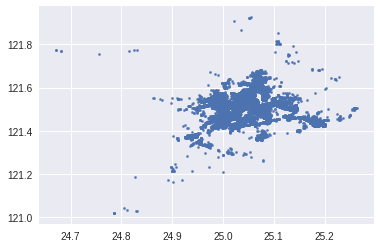

In [76]:
from matplotlib.mlab import griddata
x = X[:, 0]
y = X[:, 1]
# define grid.
# xi = np.linspace(x.min()-1, x.max()+1, 10000)
# yi = np.linspace(y.min()-1, y.max()+1, 10000)
# # grid the data.
# zi = griddata(x, y, z, xi, yi, interp='linear')
# # contour the gridded data, plotting dots at the nonuniform data points.
# CS = plt.contour(xi, yi, zi, 15, linewidths=0.5, colors='k')
# CS = plt.contourf(xi, yi, zi, 15,
#                   vmax=abs(zi).max(), vmin=-abs(zi).max())
# plt.colorbar()  # draw colorbar
# plot data points.
plt.scatter(x, y, marker='o', s=5, zorder=10)
# plt.xlim(-2, 2)
# plt.ylim(-2, 2)
# plt.title('griddata test (%d points)' % npts)
plt.show()

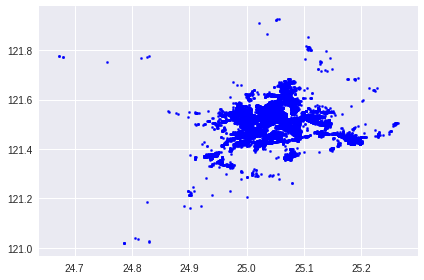

In [77]:
plt.scatter(X[:, 0], X[:, 1], c='b', marker='o', s=5)
plt.grid(True)
plt.tight_layout()
plt.show()

TypeError: Cannot cast array data from dtype('O') to dtype('float64') according to the rule 'safe'

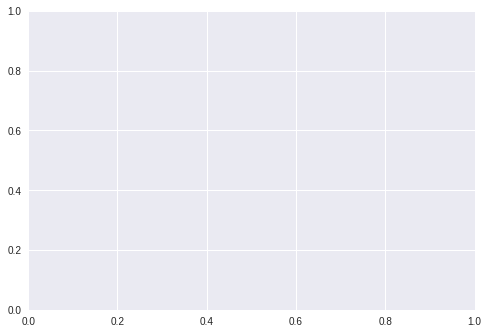

In [38]:
plt.hist2d(X[:, 0], X[:, 1], bins=10)
plt.colorbar()
plt.grid()
plt.show()

In [36]:
import seaborn as sns; sns.set()
ax = sns.heatmap(X)

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


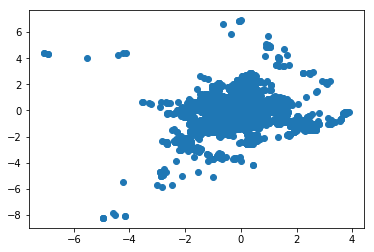

In [145]:
from sklearn.preprocessing import StandardScaler
#前處理的一種  
sc = StandardScaler() 
sc.fit(X)
X_std = sc.transform(X)
kde = KernelDensity( kernel = 'gaussian' , bandwidth = 50 ).fit(X_std)
x, y = zip(*X_std)

plt.plot(x, y, 'o')
plt.show()
# def f_kde(x,y):
#     return np.exp((kde.score_samples([[x,y]])))

# integrate.nquad(f_kde,zip(x,y))

In [ ]:
import matplotlib.pyplot as plt
import sklearn
from scipy import integrate
import numpy as np

mean = [0, 0]
cov = [[5, 0], [0, 10]]
x, y = np.random.multivariate_normal(mean, cov, 5000).T
plt.plot(x, y, 'o')
plt.show()

sample = np.array(zip(x, y))
kde = sklearn.neighbors.KernelDensity().fit(sample)
def f_kde(x,y):
    return np.exp((kde.score_samples([[x,y]])))

point = x1, y1
integrate.nquad(f_kde, [[-np.inf, x1],[-np.inf, y1]])

<function matplotlib.mlab.griddata>